Final Model Parameters:
Weights:
[[-0.65524421 -0.29838761 -0.09557361]]
Biases:
[[-0.01029112 -0.01542277  0.02571389]]


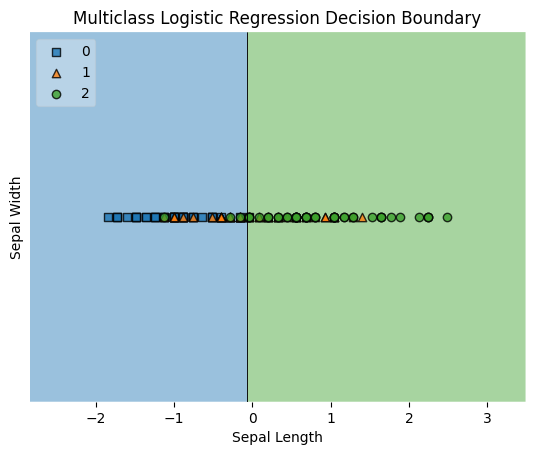

Accuracy on the test set: 64.44%


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

class MulticlassLogisticRegression:
    def __init__(self, batch_size=32, max_epochs=100, patience=3):
        """Multiclass Logistic Regression using Gradient Descent.

        Parameters:
        -----------
        batch_size: int
            The number of samples per batch.
        max_epochs: int
            The maximum number of epochs.
        patience: int
            The number of epochs to wait before stopping if the validation loss
            does not improve.
        """
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.patience = patience
        self.weights = None
        self.biases = None
        self.best_weights = None
        self.best_biases = None
        self.losses = []

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # for numerical stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y, learning_rate=0.01):
        """Fit a multiclass logistic regression model.

        Parameters:
        -----------
        X: numpy.ndarray
            The input data.
        y: numpy.ndarray
            The target values (multiclass labels).
        learning_rate: float
            The learning rate for gradient descent.
        """
        n_samples, n_features = X.shape
        _, n_classes = y.shape

        # Split data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

        # Initialize weights and biases
        self.weights = np.random.randn(n_features, n_classes)
        self.biases = np.zeros((1, n_classes))

        best_val_loss = float('inf')
        consecutive_increases = 0

        # Training loop (stochastic gradient descent)
        for epoch in range(self.max_epochs):
            for i in range(0, n_samples, self.batch_size):
                # Extract a batch
                X_batch = X_train[i:i + self.batch_size, :]
                y_batch = y_train[i:i + self.batch_size, :]

                # Check if the batch is empty
                if X_batch.shape[0] == 0:
                    continue  # Skip empty batches

                # Linear combination of inputs and current weights
                linear_model = np.dot(X_batch, self.weights) + self.biases

                # Apply softmax activation function
                predictions = self.softmax(linear_model)

                # Compute error
                error = predictions - y_batch

                # Update weights and biases using SGD
                self.weights -= learning_rate * (X_batch.T @ error) / self.batch_size
                self.biases -= learning_rate * np.sum(error, axis=0) / self.batch_size

                # Compute and record loss
                batch_loss = -np.mean(np.sum(y_batch * np.log(predictions), axis=1))
                self.losses.append(batch_loss)

            # Evaluate on validation set
            val_loss = self.score(X_val, y_val)

            # Early stopping and parameter saving
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                consecutive_increases = 0
                self.best_weights = np.copy(self.weights)
                self.best_biases = np.copy(self.biases)
            else:
                consecutive_increases += 1
                if consecutive_increases >= self.patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        # Set the final model parameters
        self.weights = self.best_weights
        self.biases = self.best_biases

        # Print the final model parameters
        print("Final Model Parameters:")
        print("Weights:")
        print(self.weights)
        print("Biases:")
        print(self.biases)

    def predict(self, X):
        """Predict using the multiclass logistic regression model.

        Parameters:
        ----------
        X: numpy.ndarray
            The input data.
        """
        linear_model = np.dot(X, self.weights) + self.biases
        predictions = self.softmax(linear_model)
        return np.argmax(predictions, axis=1)

    def score(self, X, y):
        """Evaluate the multiclass logistic regression model using the cross-entropy loss.

        Parameters:
        ----------
        X: numpy.ndarray
            The input data.
        y: numpy.ndarray
            The target data.
        """
        predictions = self.predict(X)
        loss = -np.mean(np.sum(y * np.log(self.softmax(np.dot(X, self.weights) + self.biases)), axis=1))
        return loss

    def plot_decision_boundary(self, X, y):
        """Plot the decision boundary for multiclass classification.

        Parameters:
        ----------
        X: numpy.ndarray
            The input data.
        y: numpy.ndarray
            The target data.
        """
        plot_decision_regions(X, y.flatten(), clf=self, legend=2)
        plt.xlabel('Sepal Length')
        plt.ylabel('Sepal Width')
        plt.title('Multiclass Logistic Regression Decision Boundary')
        plt.show()

    def evaluate_on_test_set(self, X_test, y_test):
        """Evaluate the multiclass logistic regression model on the test set.

        Parameters:
        ----------
        X_test: numpy.ndarray
            The test input data.
        y_test: numpy.ndarray
            The test target data.
        """
        predictions = self.predict(X_test)
        accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
        print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

    def save(self, file_path):
        """Save the model parameters to a file.

        Parameters:
        ----------
        file_path: str
            The absolute file path to save the model parameters.
        """
        # Save the model parameters
        np.savez(file_path, weights=self.weights, biases=self.biases)

    def load(self, file_path):
        """Load the model parameters from a file.

        Parameters:
        ----------
        file_path: str
            The absolute file path to load the model parameters.
        """
        loaded_params = np.load(file_path)
        self.weights = loaded_params['weights']
        self.biases = loaded_params['biases']

# Load and Preprocess Data
iris = load_iris()
X = iris.data[:, [0]]  # Selecting sepal length
y = np.eye(3)[iris.target]  # One-hot encoding for multiclass labels

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Instantiate and train the Multiclass Logistic Regression model
multiclass_logreg = MulticlassLogisticRegression(batch_size=32, max_epochs=100, patience=3)
multiclass_logreg.fit(X_train, y_train)

# Visualize the decision boundary
multiclass_logreg.plot_decision_boundary(X_train, np.argmax(y_train, axis=1))

# Save the model parameters
file_path = 'multiclass_logreg_model_sepal_length.npz'
multiclass_logreg.save(file_path)

# Load the model parameters
loaded_model = MulticlassLogisticRegression(batch_size=32, max_epochs=100, patience=3)
loaded_model.load(file_path)

# Create and standardize the test set for Sepal Length
X_test, _, y_test, _ = train_test_split(X, y, test_size=0.1, random_state=42)
X_test = scaler.transform(X_test)

# Evaluate on the test set
multiclass_logreg.evaluate_on_test_set(X_test, y_test)